<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a>


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1>Objective</h1><ul><li> How to use linear classifier in pytorch.</li></ul>


<h1>(Linear)  Classifier with PyTorch </h1>


This exercise only used fully connected layer, but it is simple, therefore, the model is updated a little.

<p>Before you use a  Deep neural network to solve the classification problem,  it 's a good idea to try and solve the problem with the simplest method. You will need the dataset object from the previous section.
In this lab, we solve the problem with a linear classifier.
 You will be asked to determine the maximum accuracy your linear classifier can achieve on the validation data for 5 epochs. We will give some free parameter values if you follow the instructions you will be able to answer the quiz. Just like the other labs there are several steps, but in this lab you will only be quizzed on the final result. </p>


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#download_data"> Download data</a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#trasform_Data_object">Transform Object and Dataset Object</a></li>
    <li><a href="#Question">Question</a></li>
</ul>
<p>Estimated Time Needed: <strong>25 min</strong></p>
 </div>
<hr>


<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab:


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
#import skillsnetwork

<h2 id="download_data">Download Data</h2>


In this section, you are going to download the data from IBM object storage using **skillsnetwork.prepare** command. <b>skillsnetwork.prepare</b> is a command that's used to download a zip file, unzip it and store it in a specified directory. Locally we store the data in the directory  **/resources/data**.


First, we download the file that contains the images:


In [ ]:
#await skillsnetwork.prepare("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip", path = "/resources/data", overwrite=True)
import requests

# URL of the file
url = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip"

# Send GET request
response = requests.get(url)

# Save the file locally
with open("concrete_crack_images_for_classification.zip", "wb") as file:
    file.write(response.content)

print("Download completed.")
import zipfile
path = "/content/concrete_crack_images_for_classification.zip"
with zipfile.ZipFile(path,"r") as zip_ref:
    zip_ref.extractall("/content")


Download completed.


<h2 id="data_class">Dataset Class</h2>


In this section, we will use the previous code to build a dataset class. As before, make sure the even samples are positive, and the odd samples are negative.  In this case, if the parameter <code>train</code> is set to <code>True</code>, use the first 10 000 samples as training data; otherwise, the last 10 000 samples will be used as validation data. Do not forget to sort your files so they are in the same order.  


**Note:** We are using the first 10,000 samples as our training data instead of the available 30,000 to decrease the training time of the model. If you want, you can train it yourself with all 30,000 samples just by modifying 2 lines in the following code chunk.


In [ ]:
# My dataset class
class My_dataset(Dataset):

  # Constructor
  def __init__(self, neg_dir, pos_dir, transform=None, train=True):
    self.transform = transform
    #neg_dir = "/content/Negative"
    negative_files = [os.path.join(neg_dir, file) for file in os.listdir(neg_dir) if file.endswith(".jpg")]
    negative_files.sort()
    positive_files = [os.path.join(pos_dir, file) for file in os.listdir(pos_dir) if file.endswith(".jpg")]
    positive_files.sort()

    # Containing labels
    self.Y=torch.zeros([len(positive_files) * 2])
    self.Y=self.Y.type(torch.LongTensor)
    self.Y[::2]=1
    self.Y[1::2]=0

    # Containing images paths
    self.all_files = []
    for i in range(len(positive_files)):
      self.all_files.append(positive_files[i])
      self.all_files.append(negative_files[i])

    if train:
      self.all_files=self.all_files[0:10000] #Only get 10000
      self.Y=self.Y[0:10000]

    else:
      self.all_files=self.all_files[30000:]
      self.Y=self.Y[30000:]
    self.len=len(self.all_files)

  def __len__(self):
    return self.len

  # Getter
  def __getitem__(self, idx):
    img = self.all_files[idx]
    img = Image.open(img).convert('RGB')
    label = self.Y[idx]


    if self.transform:
      img = self.transform(img)
    return img, label
neg_dir = "/content/Negative"
pos_dir = "/content/Positive"
imgs_1 = My_dataset(neg_dir, pos_dir, transform=None, train=True)

for i in range(4):
  print(imgs_1[i][1])
  print("___________________")

tensor(1)
___________________
tensor(0)
___________________
tensor(1)
___________________
tensor(0)
___________________


<h2 id="trasform_Data_object">Transform Object and Dataset Object</h2>


Create a transform object, that uses the <code>Compose</code> function. First use the transform <code>ToTensor()</code> and followed by <code>Normalize(mean, std)</code>. The value for <code> mean</code> and <code>std</code> are provided for you.


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])


Create object for the training data  <code>dataset_train</code> and validation <code>dataset_val</code>. Use the transform object to convert the images to tensors using the transform object:


In [ ]:
dataset_train=My_dataset(neg_dir, pos_dir, transform=transform, train=True)
dataset_val=My_dataset(neg_dir, pos_dir, transform=transform, train=False)

We  can find the shape of the image:


In [ ]:
print(dataset_train[0][0].shape)
img_dim = dataset_train[0][0].shape
img_dim

torch.Size([3, 227, 227])


torch.Size([3, 227, 227])

We see that it's a color image with three channels:


In [ ]:
size_of_image=3*227*227
size_of_image

154587

<h2 id="Question"> Question <h2>


<b> Create a custom module for Softmax for two classes,called model. The input size should be the <code>size_of_image</code>, you should record the maximum accuracy achieved on the validation data for the different epochs. For example if the 5 epochs the accuracy was 0.5, 0.2, 0.64,0.77, 0.66 you would select 0.77.</b>


Given an input of shape (height, width, channels):

Output Height = (Input Height - Kernel Height + 2 * Padding) / Stride + 1

Output Width = (Input Width - Kernel Width + 2 * Padding) / Stride + 1

Output Channels = Number of filters

MaxPooling2d:

Output Height = (Input Height - Pool Height) / Pool Stride + 1

Output Width = (Input Width - Pool Width) / Pool Stride + 1

In [ ]:
def after_conv2d(h, w, p, s, k, f): #Mostly we use the same height and width for kernel => k
  new_h = (h - k + 2 * p) / s + 1
  new_w = (w - k + 2 * p) / s + 1
  new_c = f
  return new_h, new_w, p, s, k, new_c

after_conv1_ = after_conv2d(227, 227, 1, 1, 3, 128)
# after maxpooling2d: reduce 2 => (113, 113, 1, 1, 3, 128)
print(after_conv1_)
after_conv2_ = after_conv2d(113, 113, 1, 1, 3, 64)
print(after_conv2_)
# after maxpooling2d: reduce 2 => image: 56 * 56 * 64

(227.0, 227.0, 1, 1, 3, 128)
(113.0, 113.0, 1, 1, 3, 64)


In [ ]:
113//2

56

In [ ]:
def after_max_pool2d(h,w,ph,pw,ps, padding):
  # The channel remains unchanged
  new_h = (h+2*padding - ph) / ps + 1

  new_w = (w+2*padding - pw) / ps + 1
  return new_h, new_w

after_pool1 = after_max_pool2d(227, 227, 3,3, 2,0)
after_pool1

(113.0, 113.0)

** Calculation **
Because our image is of dim: 3*227*227, therefore we have:

img_height = 227

img_width = 227

img_channels = 3

**Custom Module**

In [ ]:
# Create a cumstom model in Torch
class My_Model(nn.Module):

  def __init__(self, image_dim, num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=image_dim[0], out_channels=32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
    self.fc = nn.Linear(in_features=56 * 56 * 16, out_features=num_classes) #=> calculate by hands
    self.relu = nn.ReLU()


  def forward(self, images):
    x = self.relu(self.conv1(images))
    x = self.pool1(x)
    x = self.relu(self.conv2(x))
    x = self.pool2(x)
    # Flatten the image
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x






Train the model with the following free parameter values:


<b>Parameter Values</b>
   <li>learning rate:0.1 </li>
   <li>momentum term:0.1 </li>
   <li>batch size training:5</li>
   <li>Loss function:Cross Entropy Loss </li>
   <li>epochs:5</li>
   <li>set: torch.manual_seed(0)</li>


In [ ]:
torch.manual_seed(0)

<b>Model Object:</b>


In [ ]:
model = My_Model(img_dim,2)

<b>Optimizer:</b>


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.1)


<b>Criterion:</b>


In [ ]:
criterion = nn.CrossEntropyLoss()

<b>Data Loader Training and Validation:</b>


In [ ]:
dataloader_train = DataLoader(dataset_train, batch_size=256, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=64)

<b>Train Model with 5 epochs, should take 35 minutes: </b>


In [ ]:
import copy
best_model = copy.deepcopy(model.state_dict()) #copy the wieghts and biases
best_val_loss = float('inf')  # Initialize to store the best validation loss
EPOCHS = 2
for epoch in range(EPOCHS):
  model.train()  # Set the model to training mode (in case of normalization if any)
  loss_ = 0.0


  for batch, (inputs, labels) in enumerate(dataloader_train):

    optimizer.zero_grad() #zero the parameter gradients
    predictions = model(inputs) #Forward pass
    current_loss = criterion(predictions, labels) #Compute the loss
    current_loss.backward() # Compute gradient
    optimizer.step() #Update the parameters
    loss_ += current_loss.item() #accumulate the loss

    if batch % 2 == 0:
      print(f'step={batch + 1}/{len(dataloader_train)} - epoch = {epoch+1}/{EPOCHS}, Training Loss: {loss_/(batch + 1):.4f}')


  # validation phase
  model.eval() #Set the model to evaluation mode
  val_loss = 0.0 #Initialize validation loss
  correct = 0 #Initialize correct predictions counter
  total = 0 #Initialize total predictions counter

  # Test on the val to get the best model
  with torch.no_grad():
    for batch, (images, labels) in enumerate(dataloader_val):
      predictions = model(images)
      current_loss = criterion(predictions, labels) # Get 1 vector
      val_loss += current_loss.item()

      # Calculate the accuracy
      _, predicted = torch.max(predictions, 1) #Get the indices of the classes with largest value
      correct += (predicted == labels).sum().item()
      total += labels.size(0)
  # Average the validation loss
  val_loss /= len(dataloader_val)
  loss_ /= len(dataloader_train)
  # Print the results for the current epoch
  accuracy = correct / total * 100
  # Print the results for the current epoch
  print(f'Epoch {epoch+1}/{EPOCHS} - Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')



  # Save the model if it's the best one so far
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      best_model = copy.deepcopy(model.state_dict())


step=1/40 - epoch = 1/2, Training Loss: 0.6945
step=3/40 - epoch = 1/2, Training Loss: 1.1584
step=5/40 - epoch = 1/2, Training Loss: 1.1497
step=7/40 - epoch = 1/2, Training Loss: 1.0318
step=9/40 - epoch = 1/2, Training Loss: 0.9639
step=11/40 - epoch = 1/2, Training Loss: 0.8568
step=13/40 - epoch = 1/2, Training Loss: 0.7824
step=15/40 - epoch = 1/2, Training Loss: 0.7240
step=17/40 - epoch = 1/2, Training Loss: 0.6934
step=19/40 - epoch = 1/2, Training Loss: 0.6542
step=21/40 - epoch = 1/2, Training Loss: 0.6165
step=23/40 - epoch = 1/2, Training Loss: 0.5976
step=25/40 - epoch = 1/2, Training Loss: 0.5710
step=27/40 - epoch = 1/2, Training Loss: 0.5493
step=29/40 - epoch = 1/2, Training Loss: 0.5266
step=31/40 - epoch = 1/2, Training Loss: 0.5658
step=33/40 - epoch = 1/2, Training Loss: 0.5883
step=35/40 - epoch = 1/2, Training Loss: 0.5998
step=37/40 - epoch = 1/2, Training Loss: 0.6074
step=39/40 - epoch = 1/2, Training Loss: 0.6130
Epoch 1/2 - Validation Loss: 0.7235, Accuracy

In [ ]:
tensor = torch.tensor([[1, 2, 6],
                       [4, 5, 2]])

_,values = torch.max(tensor, dim=1)
print(values)

tensor([2, 1])


## Test wall with crack

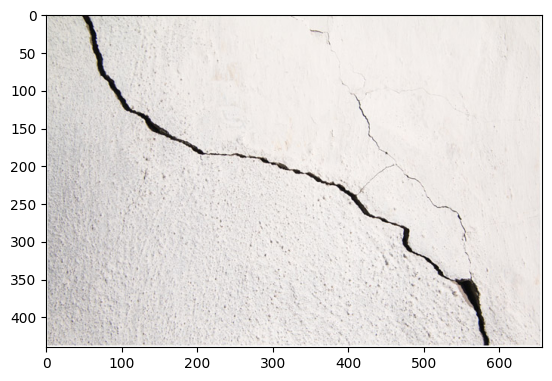

In [ ]:
# Test the image
# Define the resize transformation
image_test = "/content/hairline-crack-wall.jpg"
img_ = Image.open(image_test).convert('RGB')
#resize_transform = transforms.Resize((227, 227))
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])


resize_transform =transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Apply the resize transformation
resized_image = resize_transform(img_).view(1,3,227, 227)
#resized_image = resized_image.permute(1, 2, 0)  # Change the order of dimensions to HWC for plotting
plt.imshow(img_)
plt.show()


In [ ]:
resized_image.shape

torch.Size([1, 3, 227, 227])

In [ ]:
resized_image
with torch.no_grad():
  predictions = model(resized_image)
_, predicted = torch.max(predictions, 1) #Get the indices of the classes with largest value

In [ ]:
predicted

tensor([1])

## Test wall with no crack

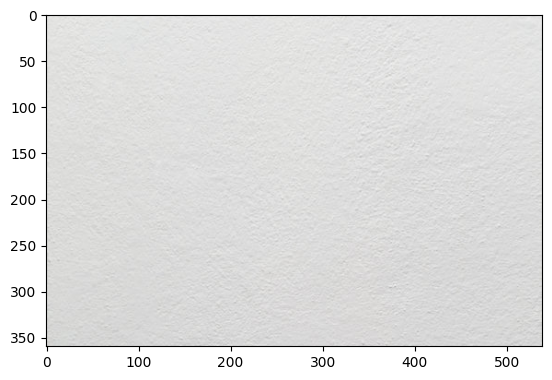

In [ ]:
# Test the image
# Define the resize transformation
image_test = "/content/wall_no_crack.jpg"
img_ = Image.open(image_test).convert('RGB')
#resize_transform = transforms.Resize((227, 227))
#mean = [0.485, 0.456, 0.406]
#std = [0.229, 0.224, 0.225]
# transforms.ToTensor()
#transforms.Normalize(mean, std)
#transforms.Compose([])


resize_transform =transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Apply the resize transformation
resized_image = resize_transform(img_).view(1,3,227, 227)
#resized_image = resized_image.permute(1, 2, 0)  # Change the order of dimensions to HWC for plotting
plt.imshow(img_)
plt.show()


In [ ]:
resized_image
with torch.no_grad():
  predictions = model(resized_image)
_, predicted = torch.max(predictions, 1) #Get the indices of the classes with largest value
predicted

tensor([0])

<h2>About the Authors:</h2>
 <a href=\"https://www.linkedin.com/in/joseph-s-50398b136/\">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-18  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



Copyright &copy; 2019 <a href="cognitiveclass.ai"> cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>
